In [60]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install lightgbm
!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [7]:
data_path = "D:\mini_projects\creadit card transaction dataset\dataset\credit_card_transactions.csv"
df = pd.read_csv(data_path)
df.head = (df,10)
print(df.head)
shape = ("shape:",df.shape)
print(shape)


<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\alexi\AppData\Local\Temp\ipykernel_4468\2742115566.py:1: SyntaxWarning: invalid escape sequence '\m'
  data_path = "D:\mini_projects\creadit card transaction dataset\dataset\credit_card_transactions.csv"


(         Unnamed: 0 trans_date_trans_time               cc_num  \
0                 0   2019-01-01 00:00:18     2703186189652095   
1                 1   2019-01-01 00:00:44         630423337322   
2                 2   2019-01-01 00:00:51       38859492057661   
3                 3   2019-01-01 00:01:16     3534093764340240   
4                 4   2019-01-01 00:03:06      375534208663984   
...             ...                   ...                  ...   
1296670     1296670   2020-06-21 12:12:08       30263540414123   
1296671     1296671   2020-06-21 12:12:19     6011149206456997   
1296672     1296672   2020-06-21 12:12:32     3514865930894695   
1296673     1296673   2020-06-21 12:13:36     2720012583106919   
1296674     1296674   2020-06-21 12:13:37  4292902571056973207   

                                    merchant       category     amt  \
0                 fraud_Rippin, Kub and Mann       misc_net    4.97   
1            fraud_Heller, Gutmann and Zieme    grocery_pos  107

In [8]:
missing = df.isna().mean().sort_values(ascending=False) * 100
print("Missing value % (top 15 columns):")
print(missing.head(15).round(2))

Missing value % (top 15 columns):
merch_zipcode            15.11
Unnamed: 0                0.00
cc_num                    0.00
trans_date_trans_time     0.00
category                  0.00
amt                       0.00
first                     0.00
merchant                  0.00
last                      0.00
gender                    0.00
city                      0.00
street                    0.00
zip                       0.00
lat                       0.00
long                      0.00
dtype: float64


In [ ]:
for col in df.columns:
    print(col)
df["is_fraud"] = df["is_fraud"].astype(int)
print(df["is_fraud"].value_counts(normalize = True).rename("Fraction")) 

df["is_fraud"].value_counts().plot(
    xlabel="class",
    ylabel="counts",
    kind = "bar",
    title= "Fraud vs Non-Fraud count",
    rot = 0
)
plt.show()

Unnamed: 0
trans_date_trans_time
cc_num
merchant
category
amt
first
last
gender
street
city
state
zip
lat
long
city_pop
job
dob
trans_num
unix_time
merch_lat
merch_long
is_fraud
merch_zipcode


In [24]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split
x = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
) 

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------  8.7/8.7 MB 53.4 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 45.1 MB/s  0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   --------------- ------------------------ 15.2/38.5 MB 68.2 MB/s eta 0:00:01
   --------------------------------- ------ 32.2/38.5 MB 78.6 MB/s eta 0:00:01
   ---------------------------------------- 38.5/38.5 MB 64.4 MB/s  0:00:00
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------

In [25]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

# Split while preserving class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Check class distribution in each split
print("Train set:\n", y_train.value_counts(normalize=True))
print("\nTest set:\n", y_test.value_counts(normalize=True))


Train set:
 is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

Test set:
 is_fraud
0    0.994212
1    0.005788
Name: proportion, dtype: float64


In [26]:
from sklearn.preprocessing import LabelEncoder

# Copy dataframe to avoid changing original
df_encoded = df.copy()

# List of columns to Label Encode (many unique values)
label_cols = ["merchant", "job", "street", "first", "last", "city"]

# Apply label encoding
le = LabelEncoder()
for col in label_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# One-Hot Encode smaller categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=["gender", "category", "state"], drop_first=True)

print("Encoded dataset shape:", df_encoded.shape)

Encoded dataset shape: (1296675, 85)


In [33]:
# --- Fix potential leakage in merchant names ---
df_encoded = df.copy()
df_encoded["merchant"] = df_encoded["merchant"].astype(str).str.replace(r"^fraud_", "", regex=True)

from sklearn.preprocessing import LabelEncoder

label_cols = ["merchant", "job", "street", "first", "last", "city"]
le_map = {}  # keep encoders if you want to reuse later

for col in label_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    le_map[col] = le  # optional: store encoder

# One-Hot Encode low-cardinality categoricals
df_encoded = pd.get_dummies(df_encoded, columns=["gender", "category", "state"], drop_first=True)

print("Encoded dataset shape:", df_encoded.shape)

import numpy as np
import pandas as pd

# Target
y = df_encoded["is_fraud"].astype(int)

# Start from encoded copy and drop target + obvious leakage/IDs
drop_cols = [
    "is_fraud",
    "trans_num",                # unique ID
    "trans_date_trans_time",    # string datetime
    "dob",                      # raw datetime (we'll engineer age later)
    "cc_num"                    # unique per card; often causes leakage-like memorization
]
X = df_encoded.drop(columns=[c for c in drop_cols if c in df_encoded.columns], errors="ignore")

# Keep only numeric columns and fill any NA
X = X.select_dtypes(include=[np.number]).fillna(0)

X.shape, X.columns[:10]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(y_train.mean(), y_test.mean())  # ~0.0058 in both

import re
import numpy as np

def sanitize_colnames(cols):
    new = []
    seen = set()
    for c in cols:
        s = re.sub(r'[^0-9A-Za-z_]+', '_', str(c))   # replace bad chars with _
        s = re.sub(r'_{2,}', '_', s).strip('_')      # collapse/trim _
        if not s: s = "col"
        base = s
        i = 1
        while s in seen:                              # ensure uniqueness
            s = f"{base}_{i}"
            i += 1
        seen.add(s)
        new.append(s)
    return new

# Rebuild X to be safe, then sanitize
y = df_encoded["is_fraud"].astype(int)

drop_cols = ["is_fraud", "trans_num", "trans_date_trans_time", "dob", "cc_num"]
X = df_encoded.drop(columns=[c for c in drop_cols if c in df_encoded.columns], errors="ignore")

X = X.select_dtypes(include=[np.number]).fillna(0)   # numeric only
X.columns = sanitize_colnames(X.columns)             # <-- sanitize names
X = X.astype(np.float32)                             # optional: speed/memory

# Split again after sanitizing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Encoded dataset shape: (1296675, 85)
0.00578884454470087 0.005787880540613492


In [34]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

clf = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:, 1]
roc = roc_auc_score(y_test, proba)
pr  = average_precision_score(y_test, proba)
print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4025
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC-AUC: 0.9937 | PR-AUC: 0.8239


In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
import numpy as np

# Get PR curve on the test set
prec, rec, thr = precision_recall_curve(y_test, proba)

# (A) threshold that maximizes F1
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
ix_f1 = np.nanargmax(f1)
thr_f1 = thr[ix_f1]
print(f"Best F1 threshold ~ {thr_f1:.4f} | Precision={prec[ix_f1]:.3f} Recall={rec[ix_f1]:.3f} F1={f1[ix_f1]:.3f}")

# (B) optional: threshold for target precision (e.g., 0.20)
target_precision = 0.20
valid = np.where(prec[:-1] >= target_precision)[0]
thr_p = thr[valid[np.argmax(rec[valid])]] if len(valid) else 0.5
print(f"Threshold for ≥{target_precision:.0%} precision ~ {thr_p:.4f}")

# Choose your threshold (use thr_f1 for now)
thr_use = thr_f1
y_pred = (proba >= thr_use).astype(int)

print("\nClassification report @ chosen threshold:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion matrix [tn fp; fn tp]:")
print(confusion_matrix(y_test, y_pred))

def recall_at_top_k(y_true, scores, frac=0.005):
    K = max(1, int(frac * len(scores)))
    idx = np.argsort(-scores)[:K]
    return y_true.iloc[idx].sum() / y_true.sum() if y_true.sum() > 0 else 0.0

print("Recall@Top0.5%:", round(recall_at_top_k(y_test, proba, 0.005), 3))
print("Recall@Top1%  :", round(recall_at_top_k(y_test, proba, 0.01), 3))


Best F1 threshold ~ 0.9492 | Precision=0.850 Recall=0.702 F1=0.769
Threshold for ≥20% precision ~ 0.3445

Classification report @ chosen threshold:
              precision    recall  f1-score   support

           0     0.9983    0.9993    0.9988    257834
           1     0.8500    0.7022    0.7691      1501

    accuracy                         0.9976    259335
   macro avg     0.9241    0.8507    0.8839    259335
weighted avg     0.9974    0.9976    0.9974    259335

Confusion matrix [tn fp; fn tp]:
[[257648    186]
 [   447   1054]]


In [38]:
import numpy as np
import pandas as pd

# 1) ensure datetime is parsed (idempotent)
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"], errors="coerce")

# 2) basic time parts
dt = df["trans_date_trans_time"]
df["hour"]        = dt.dt.hour.astype("int8")
df["dayofweek"]   = dt.dt.dayofweek.astype("int8")      # Mon=0 ... Sun=6
df["month"]       = dt.dt.month.astype("int8")
df["is_weekend"]  = (df["dayofweek"] >= 5).astype("int8")

# 3) optional: useful flags
df["is_night"]          = ((df["hour"] >= 22) | (df["hour"] <= 5)).astype("int8")
df["is_business_hours"] = ((df["hour"] >= 9) & (df["hour"] <= 17)).astype("int8")

# 4) cyclic encodings (captures wrap-around of hours/days)
df["hour_sin"]      = np.sin(2 * np.pi * df["hour"] / 24).astype("float32")
df["hour_cos"]      = np.cos(2 * np.pi * df["hour"] / 24).astype("float32")
df["dow_sin"]       = np.sin(2 * np.pi * df["dayofweek"] / 7).astype("float32")
df["dow_cos"]       = np.cos(2 * np.pi * df["dayofweek"] / 7).astype("float32")

# 5) numeric time (fast for models) — already have unix_time; add day-of-year too
df["dayofyear"] = dt.dt.dayofyear.astype("int16")

# 6) quick sanity checks
print("New time features:", ["hour","dayofweek","month","is_weekend","is_night","is_business_hours",
                             "hour_sin","hour_cos","dow_sin","dow_cos","dayofyear"])
print(df[["hour","dayofweek","month","is_weekend","is_night","is_business_hours"]].head())

# NOTE: keep 'trans_date_trans_time' for now (human-readable); we'll drop it before training.


New time features: ['hour', 'dayofweek', 'month', 'is_weekend', 'is_night', 'is_business_hours', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dayofyear']
   hour  dayofweek  month  is_weekend  is_night  is_business_hours
0     0          1      1           0         1                  0
1     0          1      1           0         1                  0
2     0          1      1           0         1                  0
3     0          1      1           0         1                  0
4     0          1      1           0         1                  0


In [40]:
from math import radians, sin, cos, sqrt, atan2

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Vectorized haversine distance in km.
    """
    # convert to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# Distance from home location to merchant
df["dist_home_merch"] = haversine_np(
    df["long"], df["lat"], df["merch_long"], df["merch_lat"]
).astype("float32")

# Optional: categorize distances
df["dist_category"] = pd.cut(
    df["dist_home_merch"],
    bins=[-1, 1, 10, 50, 100, 500, 1000, np.inf],
    labels=["<1km", "1-10km", "10-50km", "50-100km", "100-500km", "500-1000km", ">1000km"]
)

print(df[["dist_home_merch", "dist_category"]].head())


   dist_home_merch dist_category
0        78.597565      50-100km
1        30.212175       10-50km
2       108.206085     100-500km
3        95.673233      50-100km
4        77.556747      50-100km


In [ ]:
# Aggregate statistics per customer
customer_stats = df.groupby("cc_num").agg(
    mean_amt=("amt", "mean"),
    std_amt=("amt", "std"),
    median_amt=("amt", "median"),
    max_amt=("amt", "max"),
    mean_distance=("dist_home_merch", "mean"),
    transaction_count=("amt", "count")
).reset_index()

# Merge back into main dataset
df = df.merge(customer_stats, on="cc_num", how="left")

print(df.head())

#Fraud detection models love “recency” signals — if someone’s card is used twice in 1 minute in far locations, that’s suspicious.
df = df.sort_values(["cc_num", "trans_date_trans_time"])
df["prev_trans_time"] = df.groupby("cc_num")["trans_date_trans_time"].shift(1)
df["time_since_last_trans"] = (
    pd.to_datetime(df["trans_date_trans_time"]) - pd.to_datetime(df["prev_trans_time"])
).dt.total_seconds().fillna(0)


   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...  dow_cos dayofyear  \
0    Banks      F                561 Perry Cove  ...  0.62349         1   
1     Gill      F  43039 Riley Greens Suite 393  ...  0.

In [44]:
# --- TIME-BASED VELOCITY FEATURES (robust) ---

# Ensure datetime and sort properly
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df = df.sort_values(["cc_num", "trans_date_trans_time"]).reset_index(drop=True)

# 1) Time since last transaction (minutes) per card
df["time_since_last_txn"] = (
    df.groupby("cc_num")["trans_date_trans_time"]
      .diff()
      .dt.total_seconds()
      .div(60)
)
# First txn per card has NaN; set to 0 (or a large number if you prefer)
df["time_since_last_txn"] = df["time_since_last_txn"].fillna(0).astype("float32")

# 2) Rolling features over 1h and 24h windows (per card)
def add_rolling(g):
    # index by datetime for time-based rolling
    g = g.set_index("trans_date_trans_time").sort_index()

    # counts and sums in the past 1 hour
    g["txn_count_last_1h"]  = g["amt"].rolling("1h").count()
    g["total_amt_last_1h"]  = g["amt"].rolling("1h").sum()

    # counts and sums in the past 24 hours
    g["txn_count_last_24h"] = g["amt"].rolling("24h").count()
    g["total_amt_last_24h"] = g["amt"].rolling("24h").sum()

    # restore the column (not index) for merge back
    return g.reset_index()

df = (
    df.groupby("cc_num", group_keys=False)
      .apply(add_rolling)
)

# Initial rows in each group will have NaNs due to the window start; fill with 0
fill_cols = ["txn_count_last_1h", "total_amt_last_1h",
             "txn_count_last_24h", "total_amt_last_24h"]
df[fill_cols] = df[fill_cols].fillna(0).astype("float32")

print("Added:", ["time_since_last_txn"] + fill_cols)
df[[*["cc_num","trans_date_trans_time"], "time_since_last_txn", *fill_cols]].head()


Added: ['time_since_last_txn', 'txn_count_last_1h', 'total_amt_last_1h', 'txn_count_last_24h', 'total_amt_last_24h']


C:\Users\alexi\AppData\Local\Temp\ipykernel_4468\2260088579.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_rolling)


,cc_num,trans_date_trans_time,time_since_last_txn,txn_count_last_1h,total_amt_last_1h,txn_count_last_24h,total_amt_last_24h
0,60416207185,2019-01-01 12:47:15,0.000000,1.0,7.270000,1.0,7.270000
1,60416207185,2019-01-02 08:44:57,1197.699951,1.0,52.939999,2.0,60.209999
2,60416207185,2019-01-02 08:47:36,2.650000,2.0,135.020004,3.0,142.289993
3,60416207185,2019-01-02 12:38:14,230.633331,1.0,34.790001,4.0,177.080002
4,60416207185,2019-01-02 13:10:46,32.533333,2.0,61.970001,4.0,196.990005


In [45]:
import re
from sklearn.preprocessing import LabelEncoder

df_model = df.copy()

# Guard against label leakage in merchant names found in some synthetic datasets
df_model["merchant"] = df_model["merchant"].astype(str).str.replace(r"^fraud_", "", regex=True)

# Label-encode high-cardinality text
label_cols = ["merchant", "job", "street", "first", "last", "city"]
encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    encoders[col] = le

# One-hot for small categoricals
df_model = pd.get_dummies(df_model, columns=["gender", "category", "state"], drop_first=True)

# Target
y = df_model["is_fraud"].astype(int)


In [46]:
import numpy as np

drop_cols = [
    "is_fraud",
    "trans_num",                # unique txn id
    "trans_date_trans_time",    # raw timestamp (we keep derived time features instead)
    "dob",                      # raw personal date (we used it earlier for age if you added it; if not, keep dropped)
    "cc_num"                    # unique per card; tends to cause memorization
]

X = df_model.drop(columns=[c for c in drop_cols if c in df_model.columns], errors="ignore")

# Keep only numeric + fill NA
X = X.select_dtypes(include=[np.number]).fillna(0)

# (Optional) Sanitize column names for LightGBM
import re
def sanitize_colnames(cols):
    new, seen = [], set()
    for c in cols:
        s = re.sub(r'[^0-9A-Za-z_]+', '_', str(c))
        s = re.sub(r'_{2,}', '_', s).strip('_') or "col"
        base, i = s, 1
        while s in seen:
            s = f"{base}_{i}"; i += 1
        seen.add(s); new.append(s)
    return new
X.columns = sanitize_colnames(X.columns)

X.shape


(1296675, 39)

In [47]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Imbalance-aware baseline
clf = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=96,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6945
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC-AUC: 0.999418775541439
PR-AUC : 0.9693269377760729


Best F1 threshold ~ 0.6476 | Precision=0.934 Recall=0.908 F1=0.921

Classification report @ best F1:
              precision    recall  f1-score   support

           0     0.9995    0.9996    0.9995    257834
           1     0.9336    0.9081    0.9206      1501

    accuracy                         0.9991    259335
   macro avg     0.9665    0.9538    0.9601    259335
weighted avg     0.9991    0.9991    0.9991    259335

Confusion matrix [tn fp; fn tp]:
 [[257737     97]
 [   138   1363]]
Recall@Top0.5%: 0.841
Recall@Top1%  : 0.979


amt                    4439
total_amt_last_24h     4335
dayofyear              4223
time_since_last_txn    3611
median_amt             3508
Unnamed_0              3282
merchant               3279
total_amt_last_1h      3172
transaction_count      3087
mean_amt               2826
max_amt                2491
city_pop               2441
hour                   2384
last                   2230
street                 2201
dist_home_merch        2151
city                   2137
first                  2119
job                    2091
std_amt                1987
dtype: int32

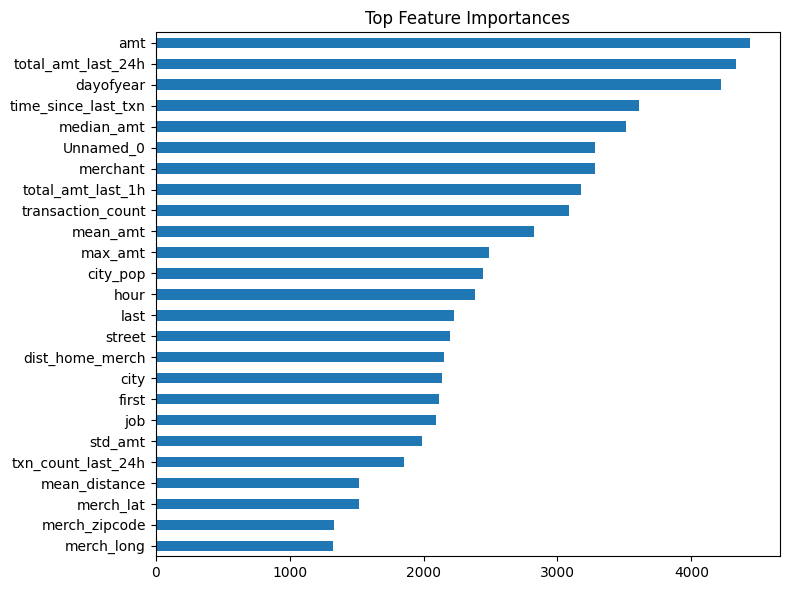

In [49]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

prec, rec, thr = precision_recall_curve(y_test, proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
ix = np.nanargmax(f1)
thr_use = thr[ix]
print(f"Best F1 threshold ~ {thr_use:.4f} | Precision={prec[ix]:.3f} Recall={rec[ix]:.3f} F1={f1[ix]:.3f}")

y_pred = (proba >= thr_use).astype(int)
print("\nClassification report @ best F1:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix [tn fp; fn tp]:\n", confusion_matrix(y_test, y_pred))

def recall_at_top_k(y_true, scores, frac=0.01):
    K = max(1, int(frac * len(scores)))
    idx = np.argsort(-scores)[:K]
    return y_true.iloc[idx].sum() / y_true.sum()

print("Recall@Top0.5%:", round(recall_at_top_k(y_test, proba, 0.005), 3))
print("Recall@Top1%  :", round(recall_at_top_k(y_test, proba, 0.01), 3))

import pandas as pd
import matplotlib.pyplot as plt

fi = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
display(fi.head(20))

plt.figure(figsize=(8,6))
fi.head(25).plot(kind="barh")
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [51]:
def make_target_encoding(col, m=100):
    """
    Smoothed target encoding:
    te = (mean_y*count + prior*m) / (count + m)
    """
    prior = df_te.iloc[train_idx]["is_fraud"].mean()
    stats = (
        df_te.iloc[train_idx][[col, "is_fraud"]]
             .groupby(col)["is_fraud"]
             .agg(["mean", "count"])
             .rename(columns={"mean":"_mean","count":"_count"})
    )
    smooth = (stats["_mean"]*stats["_count"] + prior*m) / (stats["_count"] + m)
    df_te[f"te_{col}"] = df_te[col].map(smooth).fillna(prior).astype("float32")
    return prior, smooth

for c in ["merchant", "category", "state"]:
    make_target_encoding(c, m=200)


In [52]:
# --- 1) pick features ---
# (keep engineered numeric features + target-encoded columns)
keep_cols = [
    # base numeric
    "amt","lat","long","city_pop","merch_lat","merch_long",
    # time features you created
    "hour","dayofweek","month","is_weekend","is_night","is_business_hours",
    "hour_sin","hour_cos","dow_sin","dow_cos","dayofyear",
    # geo distance features
    "dist_home_merch",
    # per-card aggregates
    "mean_amt","std_amt","median_amt","max_amt","mean_distance","transaction_count",
    # short-term velocity features
    "time_since_last_txn","txn_count_last_1h","total_amt_last_1h",
    "txn_count_last_24h","total_amt_last_24h",
    # target encodings
    "te_merchant","te_category","te_state"
]

# dist_category is ordinal-ish; map to numbers
dist_order = {"<1km":0, "1-10km":1, "10-50km":2, "50-100km":3, "100-500km":4, "500km+":5}
df_te["dist_category_num"] = df_te["dist_category"].map(dist_order).fillna(3).astype("int8")
keep_cols.append("dist_category_num")

# --- 2) basic cleaning ---
# Drop raw leakage-heavy ID/text columns from features if still present
drop_cols = [
    "Unnamed: 0","trans_date_trans_time","first","last","street","city","zip",
    "gender","state","category","merchant","trans_num","merch_zipcode"
]
X_all = df_te.drop(columns=[c for c in drop_cols if c in df_te.columns], errors="ignore")

# Keep only desired feature columns (+ make sure they exist)
keep_cols = [c for c in keep_cols if c in X_all.columns]
X_all = X_all[keep_cols].copy()

# LightGBM doesn’t like NaNs: fill them
X_all = X_all.replace([np.inf, -np.inf], np.nan).fillna(0)

y_all = df_te["is_fraud"].astype(int)

# --- 3) use the SAME indices as before to avoid leakage ---
# (assuming you still have `train_idx` and `test_idx` from the target-encoding step)
X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train, y_test = y_all.iloc[train_idx], y_all.iloc[test_idx]

# --- 4) train LightGBM ---
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import numpy as np

clf = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=64,
    min_data_in_leaf=200,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=2.0,
    class_weight="balanced",      # important for imbalance
    objective="binary",
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)

# --- 5) evaluate ---
proba = clf.predict_proba(X_test)[:, 1]
roc = roc_auc_score(y_test, proba)
pr  = average_precision_score(y_test, proba)
print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")

# tune threshold for best F1
ths = np.linspace(0.05, 0.99, 191)
best = (0, 0, 0)  # f1, th, (prec, rec)
for th in ths:
    pred = (proba >= th).astype(int)
    tp = ((pred==1)&(y_test==1)).sum()
    fp = ((pred==1)&(y_test==0)).sum()
    fn = ((pred==0)&(y_test==1)).sum()
    prec = tp / (tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp / (tp+fn) if (tp+fn)>0 else 0.0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
    if f1 > best[0]:
        best = (f1, th, (prec, rec))

best_f1, best_th, (p_b, r_b) = best
print(f"Best F1 threshold ~ {best_th:.4f} | Precision={p_b:.3f} Recall={r_b:.3f} F1={best_f1:.3f}")

# show report at best threshold
pred_best = (proba >= best_th).astype(int)
print("\nClassification report @ best F1:")
print(classification_report(y_test, pred_best, digits=4))
print("Confusion matrix [tn fp; fn tp]:")
print(confusion_matrix(y_test, pred_best))


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4763
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
ROC-AUC: 0.9996 | PR-AUC: 0.9839
Best F1 threshold ~ 0.8713 | Precision=0.964 Recall=0.938 F1=0.951

Classification report @ best F1:

In [56]:
import numpy as np
import pandas as pd

# Ensure proper dtype
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

def add_category_velocity_features(df):
    # Sort for rolling correctness and reset to RangeIndex to avoid alignment issues
    df = df.sort_values(["cc_num", "category", "trans_date_trans_time"]).reset_index(drop=True)

    g = df.groupby(["cc_num", "category"])

    # 1h window features
    c1 = (g.rolling("1h", on="trans_date_trans_time")["amt"].count()
            .reset_index(level=[0,1], drop=True))
    s1 = (g.rolling("1h", on="trans_date_trans_time")["amt"].sum()
            .reset_index(level=[0,1], drop=True))

    # 24h window features
    c24 = (g.rolling("24h", on="trans_date_trans_time")["amt"].count()
             .reset_index(level=[0,1], drop=True))
    s24 = (g.rolling("24h", on="trans_date_trans_time")["amt"].sum()
             .reset_index(level=[0,1], drop=True))

    # Assign by position to avoid reindexing errors
    df["txn_count_last_1h_category"]  = c1.fillna(0).astype("int16").to_numpy()
    df["total_amt_last_1h_category"]  = s1.fillna(0).astype("float32").to_numpy()
    df["txn_count_last_24h_category"] = c24.fillna(0).astype("int16").to_numpy()
    df["total_amt_last_24h_category"] = s24.fillna(0).astype("float32").to_numpy()

    # Optional: if you want to restore original order, merge back using a key or re-sort later
    return df

df = add_category_velocity_features(df)


In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# --- 1) Build train/test indices first (to avoid leakage in target encoding) ---
idx = np.arange(len(df))
train_idx, test_idx = train_test_split(
    idx, test_size=0.20, stratify=df["is_fraud"], random_state=42
)

prior = df.loc[train_idx, "is_fraud"].mean()

def target_encode(col, m=200):
    stats = (
        df.loc[train_idx, [col, "is_fraud"]]
          .groupby(col)["is_fraud"].agg(["mean","count"])
          .rename(columns={"mean":"_mean","count":"_count"})
    )
    smooth = (stats["_mean"]*stats["_count"] + prior*m) / (stats["_count"] + m)
    out = df[col].map(smooth).fillna(prior).astype("float32")
    df[f"te_{col}"] = out

# --- 2) Encode remaining object columns ---
# gender -> binary
df["gender_bin"] = df["gender"].map({"F":0, "M":1}).fillna(0).astype("int8")

# high-cardinality or multi-class objects -> target encoding
for c in ["job", "dist_category"]:
    if c in df.columns:
        target_encode(c, m=200)

# (You already created te_merchant/te_category/te_state earlier; keep them.)

# --- 3) Build feature matrix purely numeric to keep LightGBM happy ---
exclude = {
    "is_fraud","trans_num","dob","first","last","street","city","state","zip",
    "merchant","category","cc_num","trans_date_trans_time","Unnamed: 0",
    "gender","job","dist_category"  # raw object cols
}
num_cols = df.select_dtypes(include=[np.number]).columns
feature_cols = [c for c in num_cols if c not in exclude]

X = df[feature_cols]
y = df["is_fraud"].astype(int)

# --- 4) Train/test split and train model ---
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix
import lightgbm as lgb

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

clf = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=2.0,
    min_data_in_leaf=200,
    scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
    objective="binary",
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, proba)
pr  = average_precision_score(y_test, proba)
print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")

prec, rec, thr = precision_recall_curve(y_test, proba)
f1s = 2*prec*rec/(prec+rec + 1e-12)
best_ix = np.nanargmax(f1s)
best_thr = thr[best_ix]
print(f"Best F1 threshold ~ {best_thr:.4f} | Precision={prec[best_ix]:.3f} Recall={rec[best_ix]:.3f} F1={f1s[best_ix]:.3f}")

pred = (proba >= best_thr).astype(int)
print("\nClassification report @ best F1:")
print(classification_report(y_test, pred, digits=4))
print("Confusion matrix [tn fp; fn tp]:")
print(confusion_matrix(y_test, pred))


C:\Users\alexi\AppData\Local\Temp\ipykernel_4468\39050057.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)["is_fraud"].agg(["mean","count"])


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5739
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
ROC-AUC: 0.9990 | PR-AUC: 0.9569
Best F1 threshold ~ 0.8148 | Precision=0.924 Recall=0.894 F1=0.909

Classification report @ best F

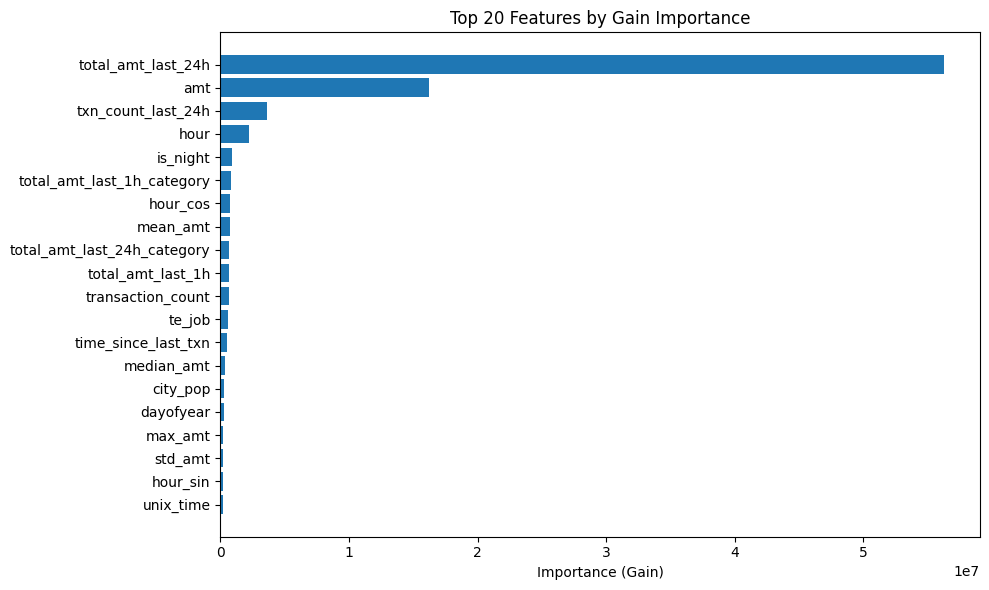

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
False Positives: 84 | False Negatives: 188

Top False Positives (highest model confidence):


,merchant,category,amt,hour,txn_count_last_1h,txn_count_last_24h,total_amt_last_1h,total_amt_last_24h,dist_home_merch,dist_category,true_label,pred_label,pred_prob
1055540,fraud_Thiel PLC,misc_pos,921.00,23,1.0,5.0,921.000000,2215.899902,73.988960,50-100km,0,1,0.999060
121436,fraud_Kunde-Sanford,misc_net,523.66,3,1.0,8.0,523.659973,5892.560059,68.048721,50-100km,0,1,0.997560
1060045,fraud_Schimmel-Olson,kids_pets,10.38,22,1.0,8.0,10.380000,4937.330078,32.133633,10-50km,0,1,0.996121
1170509,fraud_Goyette Inc,shopping_net,1105.82,23,1.0,1.0,1105.819946,1105.819946,63.435852,50-100km,0,1,0.995155
671203,fraud_McCullough LLC,misc_pos,1004.08,23,1.0,2.0,1004.080017,1044.770020,4.997728,1-10km,0,1,0.994689
1121921,fraud_Kunde-Sanford,misc_net,734.42,22,4.0,15.0,2420.469971,3336.479980,45.675903,10-50km,0,1,0.994439
695012,"fraud_Rodriguez, Yost and Jenkins",misc_net,738.40,0,1.0,3.0,738.400024,818.150024,75.996292,50-100km,0,1,0.994240
213053,"fraud_Nienow, Ankunding and Collier",misc_pos,276.38,3,1.0,5.0,276.380005,1223.420044,41.242428,10-50km,0,1,0.993690
812701,"fraud_Wuckert, Wintheiser and Friesen",home,9.93,22,2.0,5.0,2650.520020,2741.270020,62.405525,50-100km,0,1,0.989491
282905,fraud_Huel-Langworth,misc_net,1174.02,0,1.0,2.0,1174.020020,1424.010010,61.128319,50-100km,0,1,0.989180



Top False Negatives (lowest model confidence among the misses):


,merchant,category,amt,hour,txn_count_last_1h,txn_count_last_24h,total_amt_last_1h,total_amt_last_24h,dist_home_merch,dist_category,true_label,pred_label,pred_prob
452854,"fraud_Connelly, Reichert and Fritsch",gas_transport,8.01,9,1.0,2.0,8.010000,9.370000,65.775108,50-100km,1,0,0.000040
489425,fraud_Spencer PLC,entertainment,434.76,20,1.0,1.0,434.760010,434.760010,45.450314,10-50km,1,0,0.000064
1204668,"fraud_Rutherford, Homenick and Bergstrom",grocery_net,10.49,10,1.0,5.0,10.490000,164.789993,95.450089,50-100km,1,0,0.000065
250123,"fraud_Kilback, Nitzsche and Leffler",travel,2.13,14,1.0,3.0,2.130000,318.869995,79.319260,50-100km,1,0,0.000237
406574,fraud_White and Sons,home,229.57,12,1.0,1.0,229.570007,229.570007,63.447430,50-100km,1,0,0.000410
542945,"fraud_Greenholt, Jacobi and Gleason",gas_transport,22.98,11,1.0,5.0,22.980000,488.950012,96.204765,50-100km,1,0,0.000485
1101269,fraud_Kling-Grant,grocery_net,14.43,4,1.0,5.0,14.430000,557.049988,18.074718,10-50km,1,0,0.000504
343075,fraud_Abernathy and Sons,food_dining,107.36,2,1.0,2.0,107.360001,111.559998,94.896286,50-100km,1,0,0.000641
176060,fraud_Hoppe-Parisian,kids_pets,7.18,23,1.0,2.0,7.180000,58.180000,82.720856,50-100km,1,0,0.000809
1041275,fraud_Williamson LLC,misc_pos,8.94,16,1.0,1.0,8.940000,8.940000,64.605705,50-100km,1,0,0.001156


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------- 1) Feature importance (matplotlib-only) ----------
gain = np.array(clf.booster_.feature_importance(importance_type='gain'))
feat_names = np.array(clf.booster_.feature_name())
order = np.argsort(gain)[::-1][:20]  # top 20

plt.figure(figsize=(10, 6))
plt.barh(feat_names[order][::-1], gain[order][::-1])
plt.title('Top 20 Features by Gain Importance')
plt.xlabel('Importance (Gain)')
plt.tight_layout()
plt.show()

# ---------- 2) Predictions ----------
y_pred_prob = clf.predict_proba(X_test)[:, 1]
threshold = 0.8713  # your best-F1 threshold
y_pred = (y_pred_prob >= threshold).astype(int)

# ---------- 3) Build a human-readable view from ORIGINAL df rows ----------
# Pick columns you want to inspect; keep only those that exist
want_cols = [
    'merchant', 'category', 'amt', 'hour',
    'txn_count_last_1h', 'txn_count_last_24h',
    'total_amt_last_1h', 'total_amt_last_24h',
    'dist_home_merch', 'dist_category',
    'te_merchant', 'te_category', 'te_state'
]
want_cols = [c for c in want_cols if c in df.columns]

view = df.loc[test_idx, want_cols].copy()
view['true_label'] = y_test.values
view['pred_label'] = y_pred
view['pred_prob'] = y_pred_prob

# ---------- 4) Slice errors ----------
false_pos = view[(view['true_label'] == 0) & (view['pred_label'] == 1)].copy()
false_neg = view[(view['true_label'] == 1) & (view['pred_label'] == 0)].copy()

print(f"False Positives: {len(false_pos)} | False Negatives: {len(false_neg)}")

# Show a few most-informative examples
print("\nTop False Positives (highest model confidence):")
display(false_pos.sort_values('pred_prob', ascending=False).head(10))

print("\nTop False Negatives (lowest model confidence among the misses):")
display(false_neg.sort_values('pred_prob', ascending=True).head(10))


In [65]:
drop_cols = [
    'merchant','category','state','first','last','street','city','job','trans_num',
    'zip','lat','long','merch_lat','merch_long','cc_num','Unnamed: 0'
]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
# then keep your engineered numeric/TE columns for training


In [66]:
# --- 0) Housekeeping: optional cleanups / safe encodings ---------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

# If you still have a string bucket for distance, map it to an ordered int
if "dist_category" in df.columns and "dist_category_bucket_idx" not in df.columns:
    order = ["<1km","1-10km","10-50km","50-100km","100-500km",">=500km"]
    mapping = {k:i for i,k in enumerate(order)}
    df["dist_category_bucket_idx"] = df["dist_category"].map(mapping).astype("Int8")  # Int8 allows NA if any
    # If you prefer no NA at all:
    df["dist_category_bucket_idx"] = df["dist_category_bucket_idx"].fillna(-1).astype("int8")

# Drop obvious IDs / text that should NOT go into the model
drop_cols = [
    "Unnamed: 0","trans_num","first","last","street","city","job","gender",
    "merchant","category","state","cc_num","zip","lat","long","merch_lat","merch_long"
]
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# --- 1) Build a SAFE whitelist of meaningful numeric features ----------------
preferred_keep = {
    # amounts & aggregates
    "amt","mean_amt","std_amt","median_amt","max_amt","transaction_count",
    "total_amt_last_1h","total_amt_last_24h",
    "txn_count_last_1h","txn_count_last_24h",
    # time features
    "hour","dayofweek","month","is_weekend","is_night","is_business_hours",
    "hour_sin","hour_cos","dow_sin","dow_cos","dayofyear","time_since_last_txn",
    # geo / distance
    "dist_home_merch","dist_category_bucket_idx","city_pop",
    # target encodings (created earlier)
    "te_merchant","te_category","te_state",
}

# Keep only numeric/bool and present in df (robust to missing ones)
num_cols = set(df_model.select_dtypes(include=["number","bool"]).columns.tolist())
use_cols = sorted(list(preferred_keep.intersection(num_cols)))

print(f"Using {len(use_cols)} features:\n", use_cols)

# --- 2) Train / Test split ---------------------------------------------------
X = df_model[use_cols].copy()
y = df["is_fraud"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3) Train LightGBM -------------------------------------------------------
import lightgbm as lgb

clf = lgb.LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=64,
    colsample_bytree=0.8,
    subsample=0.9,
    reg_alpha=0.0,
    reg_lambda=2.0,
    min_data_in_leaf=200,
    n_jobs=-1,
    objective="binary"
)

clf.fit(X_train, y_train)

# --- 4) Evaluate -------------------------------------------------------------
proba = clf.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, proba)
pr  = average_precision_score(y_test, proba)
print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")

# Find best F1 over many thresholds
thresholds = np.linspace(0.01, 0.99, 99)
best = (0, 0, 0)  # f1, thr, (prec, rec)
for t in thresholds:
    pred = (proba >= t).astype(int)
    tp = np.sum((pred == 1) & (y_test == 1))
    fp = np.sum((pred == 1) & (y_test == 0))
    fn = np.sum((pred == 0) & (y_test == 1))
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f1 = 2*prec*rec/(prec+rec+1e-9)
    if f1 > best[0]:
        best = (f1, t, (prec, rec))

best_f1, best_thr, (best_prec, best_rec) = best
print(f"Best F1 threshold ~ {best_thr:.4f} | Precision={best_prec:.3f} Recall={best_rec:.3f} F1={best_f1:.3f}")

# Classification report & confusion matrix at best threshold
from sklearn.metrics import classification_report
pred_best = (proba >= best_thr).astype(int)
print("\nClassification report @ best F1:")
print(classification_report(y_test, pred_best, digits=4))

cm = confusion_matrix(y_test, pred_best)
print("Confusion matrix [tn fp; fn tp]:")
print(cm)

# --- 5) Top importances ------------------------------------------------------
imp = pd.Series(clf.feature_importances_, index=use_cols).sort_values(ascending=False)
print("\nTop 25 features by importance:")
print(imp.head(25))

# --- 6) (Optional) Error analysis rows (won't leak into model) --------------
# This will only include columns that exist; safe for inspection only.
try:
    test_idx = X_test.index
    err_df = df.loc[test_idx, ["merchant","category","amt","hour",
                               "txn_count_last_1h","txn_count_last_24h",
                               "total_amt_last_1h","total_amt_last_24h",
                               "dist_home_merch","dist_category"]].copy()
    err_df["true_label"] = y_test
    err_df["pred_prob"]  = proba
    err_df["pred_label"] = pred_best

    fp = err_df[(err_df["true_label"]==0) & (err_df["pred_label"]==1)].sort_values("pred_prob", ascending=False)
    fn = err_df[(err_df["true_label"]==1) & (err_df["pred_label"]==0)].sort_values("pred_prob", ascending=True)

    print(f"\nFalse Positives: {len(fp)} | False Negatives: {len(fn)}")
    print("\nTop False Positives:")
    display(fp.head(10))
    print("\nTop False Negatives:")
    display(fn.head(10))
except Exception as e:
    print(f"(Optional error table skipped: {e})")


Using 25 features:
 ['amt', 'city_pop', 'dayofweek', 'dayofyear', 'dist_category_bucket_idx', 'dist_home_merch', 'dow_cos', 'dow_sin', 'hour', 'hour_cos', 'hour_sin', 'is_business_hours', 'is_night', 'is_weekend', 'max_amt', 'mean_amt', 'median_amt', 'month', 'std_amt', 'time_since_last_txn', 'total_amt_last_1h', 'total_amt_last_24h', 'transaction_count', 'txn_count_last_1h', 'txn_count_last_24h']
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3175
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used f

,merchant,category,amt,hour,txn_count_last_1h,txn_count_last_24h,total_amt_last_1h,total_amt_last_24h,dist_home_merch,dist_category,true_label,pred_prob,pred_label
1055540,fraud_Thiel PLC,misc_pos,921.00,23,1.0,5.0,921.000000,2215.899902,73.988960,50-100km,0,0.992963,1
1060045,fraud_Schimmel-Olson,kids_pets,10.38,22,1.0,8.0,10.380000,4937.330078,32.133633,10-50km,0,0.960597,1
671203,fraud_McCullough LLC,misc_pos,1004.08,23,1.0,2.0,1004.080017,1044.770020,4.997728,1-10km,0,0.924858,1
451132,"fraud_Kilback, Nitzsche and Leffler",travel,976.97,23,1.0,1.0,976.969971,976.969971,82.901581,50-100km,0,0.919599,1
121436,fraud_Kunde-Sanford,misc_net,523.66,3,1.0,8.0,523.659973,5892.560059,68.048721,50-100km,0,0.906935,1
458629,fraud_Jast Ltd,shopping_net,21.35,10,1.0,4.0,21.350000,2768.290039,26.271662,10-50km,0,0.900671,1
282905,fraud_Huel-Langworth,misc_net,1174.02,0,1.0,2.0,1174.020020,1424.010010,61.128319,50-100km,0,0.880335,1
1186242,"fraud_Stanton, Jakubowski and Baumbach",shopping_net,887.44,6,1.0,9.0,887.440002,4194.310059,76.579582,50-100km,0,0.865696,1
96660,fraud_Bogisich-Homenick,misc_net,944.24,1,1.0,4.0,944.239990,1094.540039,67.188042,50-100km,0,0.862287,1
1170509,fraud_Goyette Inc,shopping_net,1105.82,23,1.0,1.0,1105.819946,1105.819946,63.435852,50-100km,0,0.844434,1



Top False Negatives:


,merchant,category,amt,hour,txn_count_last_1h,txn_count_last_24h,total_amt_last_1h,total_amt_last_24h,dist_home_merch,dist_category,true_label,pred_prob,pred_label
452854,"fraud_Connelly, Reichert and Fritsch",gas_transport,8.01,9,1.0,2.0,8.010000,9.370000,65.775108,50-100km,1,0.000013,0
250123,"fraud_Kilback, Nitzsche and Leffler",travel,2.13,14,1.0,3.0,2.130000,318.869995,79.319260,50-100km,1,0.000013,0
406574,fraud_White and Sons,home,229.57,12,1.0,1.0,229.570007,229.570007,63.447430,50-100km,1,0.000068,0
1101269,fraud_Kling-Grant,grocery_net,14.43,4,1.0,5.0,14.430000,557.049988,18.074718,10-50km,1,0.000094,0
489425,fraud_Spencer PLC,entertainment,434.76,20,1.0,1.0,434.760010,434.760010,45.450314,10-50km,1,0.000105,0
1204668,"fraud_Rutherford, Homenick and Bergstrom",grocery_net,10.49,10,1.0,5.0,10.490000,164.789993,95.450089,50-100km,1,0.000188,0
542945,"fraud_Greenholt, Jacobi and Gleason",gas_transport,22.98,11,1.0,5.0,22.980000,488.950012,96.204765,50-100km,1,0.000284,0
675874,fraud_Romaguera Ltd,health_fitness,19.74,23,1.0,2.0,19.740000,37.650002,69.496605,50-100km,1,0.000349,0
573525,"fraud_Schaefer, Maggio and Daugherty",gas_transport,23.29,2,1.0,3.0,23.290001,38.139999,98.810127,50-100km,1,0.000429,0
494313,"fraud_Greenholt, Jacobi and Gleason",gas_transport,8.15,8,1.0,4.0,8.150000,410.600006,3.949897,1-10km,1,0.000452,0


In [71]:
def transform(self, X):
    df = X.copy()

    # ... (datetime + basic features as before)

    # --- distance features (unchanged) ---

    # --- per-card temporal order ---
    # Reset index so we never align on duplicate labels later
    df = df.sort_values(["cc_num", "trans_date_trans_time"], kind="mergesort").reset_index(drop=True)

    # time since previous txn (minutes)
    df["time_since_last_txn"] = (
        df.groupby("cc_num")["trans_date_trans_time"]
          .diff()
          .pipe(self._to_minutes)
          .fillna(0.0)
          .astype("float32")
    )

    # --- rolling windows per card (1h, 24h) on 'amt' ---
    g_cc = df.groupby("cc_num", group_keys=False)

    # counts
    c1  = (g_cc.rolling("1h", on="trans_date_trans_time")["amt"].count()).fillna(0)
    c24 = (g_cc.rolling("24h", on="trans_date_trans_time")["amt"].count()).fillna(0)
    # sums
    s1  = (g_cc.rolling("1h", on="trans_date_trans_time")["amt"].sum()).fillna(0)
    s24 = (g_cc.rolling("24h", on="trans_date_trans_time")["amt"].sum()).fillna(0)

    # assign POSITIONALLY to avoid index alignment
    df["txn_count_last_1h"]  = c1.astype("int32").to_numpy()
    df["txn_count_last_24h"] = c24.astype("int32").to_numpy()
    df["total_amt_last_1h"]  = s1.astype("float32").to_numpy()
    df["total_amt_last_24h"] = s24.astype("float32").to_numpy()

    # --- expanding amount stats per card (shifted to avoid using current row) ---
    g_amt = df.groupby("cc_num", group_keys=False)["amt"]
    df["transaction_count"] = (g_amt.cumcount() + 1).astype("int32")

    mean_   = g_amt.expanding().mean().shift(1)
    std_    = g_amt.expanding().std().shift(1)
    median_ = g_amt.expanding().median().shift(1)
    max_    = g_amt.expanding().max().shift(1)

    # assign POSITIONALLY
    df["mean_amt"]   = mean_.fillna(0).astype("float32").to_numpy()
    df["std_amt"]    = std_.fillna(0).astype("float32").to_numpy()
    df["median_amt"] = median_.fillna(0).astype("float32").to_numpy()
    df["max_amt"]    = max_.fillna(0).astype("float32").to_numpy()

    # ... (feature_cols selection + casting exactly as before)
    return X_out


In [73]:
# 0) Drop obvious junk cols
for df_ in (X_train_raw, X_test_raw):
    if "Unnamed: 0" in df_.columns:
        df_.drop(columns=["Unnamed: 0"], inplace=True)

# 1) Ensure column names are strings and consistent (colon -> underscore, etc.)
def clean_name(c):
    return str(c).replace(":", "_").strip()

X_train_raw.columns = [clean_name(c) for c in X_train_raw.columns]
X_test_raw.columns  = [clean_name(c) for c in X_test_raw.columns]

# 2) Remove duplicate-named columns (keep first occurrence)
X_train_raw = X_train_raw.loc[:, ~X_train_raw.columns.duplicated()].copy()
X_test_raw  = X_test_raw.loc[:,  ~X_test_raw.columns.duplicated()].copy()

# 3) Make feature list unique and aligned to what's actually present
#    (adjust this to whatever you're using as your final feature list)
feature_cols = list(dict.fromkeys(feature_cols))                  # drop dupes, keep order
feature_cols = [c for c in feature_cols if c in X_train_raw.columns]

# 4) If your preprocessor/ColumnTransformer selects by column names,
#    rebuild it to use the cleaned `feature_cols` only.
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgb

preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(with_mean=False), feature_cols)],
    remainder="drop",
    verbose_feature_names_out=False
)

pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", lgb.LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.8,
        num_leaves=64,
        min_data_in_leaf=200,
        n_jobs=-1,
        objective="binary"
    ))
])

print("Using features:", feature_cols)


C:\Users\alexi\AppData\Local\Temp\ipykernel_4468\3702644165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.drop(columns=["Unnamed: 0"], inplace=True)
C:\Users\alexi\AppData\Local\Temp\ipykernel_4468\3702644165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.drop(columns=["Unnamed: 0"], inplace=True)


Using features: ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'merch_zipcode', 'hour', 'dayofweek', 'month', 'is_weekend', 'is_night', 'is_business_hours', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dayofyear', 'dist_home_merch', 'mean_amt', 'std_amt', 'median_amt', 'max_amt', 'mean_distance', 'transaction_count', 'time_since_last_txn', 'txn_count_last_1h', 'total_amt_last_1h', 'txn_count_last_24h', 'total_amt_last_24h', 'txn_count_last_1h_category', 'total_amt_last_1h_category', 'txn_count_last_24h_category', 'total_amt_last_24h_category', 'gender_bin', 'te_job', 'te_dist_category']


In [74]:
pipeline.fit(X_train_raw, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5738
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [75]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import numpy as np

proba = pipeline.predict_proba(X_test_raw)[:, 1]
roc  = roc_auc_score(y_test, proba)
pra  = average_precision_score(y_test, proba)

prec, rec, thr = precision_recall_curve(y_test, proba)
f1 = 2*prec*rec/(prec+rec+1e-12)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx]

print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pra:.4f}")
print(f"Best F1 threshold ~ {best_thr:.4f} | Precision={prec[best_idx]:.3f} Recall={rec[best_idx]:.3f} F1={f1[best_idx]:.3f}")

y_pred = (proba >= best_thr).astype(int)
print("\nReport:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


d:\mini_projects\creadit card transaction dataset\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
ROC-AUC: 0.9992 | PR-AUC: 0.9610
Best F1 threshold ~ 0.2080 | Precision=0.931 Recall=0.895 F1=0.913

Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.93      0.90      0.91      1501

    accuracy                           1.00    259335
   macro avg       0.97      0.95      0.96    259335
weighted avg       1.00      1.00      1.00    259335

Confusion matrix:
 [[257735     99]
 [   157   1344]]


In [76]:
import joblib, json

joblib.dump(pipeline, "fraud_pipeline.joblib")
joblib.dump(feature_cols, "feature_columns.pkl")
with open("inference_threshold.json","w") as f:
    json.dump({"threshold": float(best_thr)}, f)

print("Saved: fraud_pipeline.joblib, feature_columns.pkl, inference_threshold.json")


Saved: fraud_pipeline.joblib, feature_columns.pkl, inference_threshold.json


In [77]:
import pandas as pd, joblib, json

pipe   = joblib.load("fraud_pipeline.joblib")
feats  = joblib.load("feature_columns.pkl")
thr    = json.load(open("inference_threshold.json"))["threshold"]

def score_transactions(df_new: pd.DataFrame):
    # ensure same columns as training set (extra cols are ignored by ColumnTransformer)
    missing = [c for c in feats if c not in df_new.columns]
    for c in missing: df_new[c] = 0
    proba = pipe.predict_proba(df_new)[:,1]
    pred  = (proba >= thr).astype(int)
    return pd.DataFrame({"proba": proba, "pred": pred}, index=df_new.index)
